In [32]:
import pandas as pd
import numpy as np
import pickle
from pathlib import Path
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
# Load all .csv and .pkl files in the current directory into python variables.
# Files will be assigned to variables named after the file stem with non-alnum chars replaced by '_'.
# Example: "thgl-opentargets_val_ns.pkl" -> variable thgl_opentargets_val_ns

p = Path('.')  # already present in the notebook as `p` but safe to rebind
files = sorted(p.glob('*.csv'))

def _sanitize(stem: str) -> str:
    name = ''.join(ch if ch.isalnum() else '_' for ch in stem)
    if name and name[0].isdigit():
        name = '_' + name
    return name

loaded = {}
for f in files:
    var = _sanitize(f.stem)
    try:
        if f.suffix.lower() == '.csv':
            obj = pd.read_csv(f)
        else:
            with open(f, 'rb') as fh:
                obj = pickle.load(fh)
    except Exception as e:
        print(f"Failed to load {f.name}: {e!r}")
        continue
    globals()[var] = obj
    loaded[var] = obj

# Print brief summary for each loaded object
for name, obj in loaded.items():
    t = type(obj).__name__
    summary = ""
    if isinstance(obj, pd.DataFrame):
        summary = f"DataFrame, shape={obj.shape}"
    else:
        try:
            # numpy arrays, lists, dicts
            import numpy as _np  # local import to avoid assuming it's already imported elsewhere
            if isinstance(obj, _np.ndarray):
                summary = f"ndarray, shape={obj.shape}"
            elif isinstance(obj, dict):
                summary = f"dict, len={len(obj)}"
            elif isinstance(obj, (list, tuple, set)):
                summary = f"{type(obj).__name__}, len={len(obj)}"
            else:
                summary = t
        except Exception:
            summary = t
    print(f"{name}: {summary}")

# Force a specific loaded variable by hard-coded name
forced_name = 'thgl_opentargets_val_ns'  # hard-coded variable name to show
if forced_name in globals():
    obj = globals()[forced_name]
    print(f"\nForced variable -> '{forced_name}' is loaded as variable {forced_name} with type {type(obj).__name__}")
else:
    print(f"\nForced variable '{forced_name}' not found among loaded variables. Available: {sorted(loaded.keys())}")


thgl_opentargets_edgelist: DataFrame, shape=(4525578, 5)
thgl_opentargets_nodeIDmapping: DataFrame, shape=(33747, 2)
thgl_opentargets_nodetype: DataFrame, shape=(33747, 2)
thgl_opentargets_nodetype_mapping: DataFrame, shape=(5, 2)
thgl_opentargets_relation_mapping: DataFrame, shape=(9, 2)

Forced variable 'thgl_opentargets_val_ns' not found among loaded variables. Available: ['thgl_opentargets_edgelist', 'thgl_opentargets_nodeIDmapping', 'thgl_opentargets_nodetype', 'thgl_opentargets_nodetype_mapping', 'thgl_opentargets_relation_mapping']


In [34]:
df

,year,src,dst,relation_type,score,src_type,dst_type,relation_type_label
0,1906,1677,1014,1,0.10,target,disease,literature
1,1912,3097,21648,1,0.03,target,disease,literature
2,1913,7943,20518,1,0.16,target,disease,literature
3,1913,7943,22133,1,0.05,target,disease,literature
4,1916,3097,22658,1,0.02,target,disease,literature
...,...,...,...,...,...,...,...,...
4525573,2026,21865,7301,10,0.20,disease,target,clinical_trial
4525574,2026,21865,15141,10,0.20,disease,target,clinical_trial
4525575,2026,21865,892,10,0.20,disease,target,clinical_trial
4525576,2030,21797,699,10,0.05,disease,target,clinical_trial


In [35]:
# ---------------------------------------------------------
# 0. Base
# ---------------------------------------------------------
df = thgl_opentargets_edgelist.copy()

# ---------------------------------------------------------
# 1. Attach numeric src_type
# ---------------------------------------------------------
df = df.merge(
    thgl_opentargets_nodetype.rename(columns={"node_id": "src", "node_type": "src_type"}),
    on="src", how="left"
)
print("✅ complete stage 1")

# ---------------------------------------------------------
# 2. Attach numeric dst_type
# ---------------------------------------------------------
df = df.merge(
    thgl_opentargets_nodetype.rename(columns={"node_id": "dst", "node_type": "dst_type"}),
    on="dst", how="left"
)
print("✅ complete stage 2")

# ---------------------------------------------------------
# 3. Attach relation label
# ---------------------------------------------------------
df = df.merge(
    thgl_opentargets_relation_mapping.rename(
        columns={"relation": "relation_type", "relation_name": "relation_type_label"}
    ),
    on="relation_type", how="left"
)
print("✅ complete stage 3")

# ---------------------------------------------------------
# 4. Attach STRING node type labels
# ---------------------------------------------------------
label_map = thgl_opentargets_nodetype_mapping.set_index("node_type")["node_type_name"].to_dict()
df["src_type"] = df["src_type"].map(label_map)
df["dst_type"] = df["dst_type"].map(label_map)
print("✅ complete stage 4")

# ---------------------------------------------------------
# 5. Final dataframe
# ---------------------------------------------------------
thgl_opentargets_edgelist_merge = df
print("🎉 complete stage 5 — merged edge list shape:", thgl_opentargets_edgelist_merge.shape)


✅ complete stage 1
✅ complete stage 2
✅ complete stage 3
✅ complete stage 4
🎉 complete stage 5 — merged edge list shape: (4525578, 8)


In [36]:
thgl_opentargets_edgelist_merge_dynamic = thgl_opentargets_edgelist_merge[thgl_opentargets_edgelist_merge['year'] > 0]

In [37]:
thgl_opentargets_edgelist_merge_dynamic

,year,src,dst,relation_type,score,src_type,dst_type,relation_type_label
0,1906,1677,1014,1,0.10,target,disease,literature
1,1912,3097,21648,1,0.03,target,disease,literature
2,1913,7943,20518,1,0.16,target,disease,literature
3,1913,7943,22133,1,0.05,target,disease,literature
4,1916,3097,22658,1,0.02,target,disease,literature
...,...,...,...,...,...,...,...,...
4525573,2026,21865,7301,10,0.20,disease,target,clinical_trial
4525574,2026,21865,15141,10,0.20,disease,target,clinical_trial
4525575,2026,21865,892,10,0.20,disease,target,clinical_trial
4525576,2030,21797,699,10,0.05,disease,target,clinical_trial


In [48]:
# remove rows where relation_type_label == 'europepmc' AND score < 0.1
n_before = len(thgl_opentargets_edgelist_merge_dynamic)
mask = ~(
    (thgl_opentargets_edgelist_merge_dynamic["relation_type_label"] == "literature") &
    (thgl_opentargets_edgelist_merge_dynamic["score"] < 0.1)
)
thgl_opentargets_edgelist_merge_dynamic = thgl_opentargets_edgelist_merge_dynamic[mask].copy()
print(f"Removed {n_before - len(thgl_opentargets_edgelist_merge_dynamic)} rows; remaining {len(thgl_opentargets_edgelist_merge_dynamic)}")

Removed 2673835 rows; remaining 1851743


In [49]:
# Count occurrences of each (src_type, dst_type, relation_type_label) combination
comb_counts = thgl_opentargets_edgelist_merge_dynamic[
    ['src_type', 'dst_type', 'relation_type_label']
].value_counts()
comb_counts

src_type  dst_type  relation_type_label
target    disease   literature             758356
                    animal_model           449664
disease   target    clinical_trial         198692
target    disease   rna_expression         171555
                    genetic_association    129651
                    somatic_mutation        63588
                    affected_pathway        39249
          reactome  involved_in             37206
disease   reactome  associated_with          3782
Name: count, dtype: int64

In [50]:
import hashlib
import colorsys

GLASBEY_32 = [
    "#000000", "#ff0000", "#00ff00", "#0000ff", "#ffff00", "#00ffff", "#ff00ff",
    "#800000", "#008000", "#000080", "#808000", "#008080", "#800080",
    "#ff8080", "#80ff80", "#8080ff", "#ffff80", "#80ffff", "#ff80ff",
    "#ff8000", "#80ff00", "#00ff80", "#0080ff", "#8000ff",
    "#ff0080", "#00ff80", "#0080ff",
    "#c0c0c0", "#808080", "#404040", "#202020", "#e0e0e0"
]


def generate_edge_color_map(edge_types):
    """
    Assign each edge (relation) type a unique Glasbey colour.
    Works up to 32 relation types.
    """
    edge_types = sorted(edge_types)   # ensure deterministic order

    if len(edge_types) > len(GLASBEY_32):
        raise ValueError(
            f"Too many edge types ({len(edge_types)}). "
            f"Glasbey_32 supports max {len(GLASBEY_32)}."
        )

    return {
        et: GLASBEY_32[i]
        for i, et in enumerate(edge_types)
    }

def generate_node_color_map(node_types):
    """
    Assign each node type a Glasbey colour (first N entries).
    """
    node_types = sorted(node_types)

    if len(node_types) > len(GLASBEY_32):
        raise ValueError(
            f"Too many node types ({len(node_types)}). "
            f"Glasbey_32 supports max {len(GLASBEY_32)}."
        )

    return {
        nt: GLASBEY_32[i]
        for i, nt in enumerate(node_types)
    }



edge_types = df["relation_type_label"].unique()
edge_colors = generate_edge_color_map(edge_types)

node_types = set(df["src_type"]) | set(df["dst_type"])
node_colors = generate_node_color_map(node_types)

In [51]:
def node_type_per_year(df):
    """
    Calculate the count of each node type per year in the given dataframe.
    """
    if "src_type" not in df.columns or "dst_type" not in df.columns:
        return {}

    result = {}

    for y, sub in df.groupby("year"):
        nodes = pd.concat([
            sub[["src", "src_type"]].rename(columns={"src": "node", "src_type": "type"}),
            sub[["dst", "dst_type"]].rename(columns={"dst": "node", "dst_type": "type"})
        ]).drop_duplicates()

        result[y] = nodes["type"].value_counts().to_dict()

    return result

def edge_type_per_year(df):
    return {
        y: sub["relation_type_label"].value_counts().to_dict()
        for y, sub in df.groupby("year")
    }

def compute_drec(df):
    df = df.sort_values("year")
    years = sorted(df.year.unique())

    numer = 0
    denom = 0

    for i in range(len(years)-1):
        y = years[i]
        yn = years[i+1]

        E_t = set(map(tuple, df[df.year == y][["src","dst","relation_type"]].values))
        E_next = set(map(tuple, df[df.year == yn][["src","dst","relation_type"]].values))

        numer += len(E_t & E_next)
        denom += len(E_t)

    return numer / denom if denom else 0

def compute_rec(df):
    df = df.sort_values("year")
    seen = {}
    
    for y, sub in df.groupby("year"):
        edges = set(map(tuple, sub[["src", "dst", "relation_type"]].values))
        for e in edges:
            if e in seen:
                seen[e] = True
            else:
                seen[e] = False

    # proportion that repeated at least once
    return sum(seen.values()) / len(seen) if len(seen) else 0

from collections import defaultdict

def compute_consecutiveness(df):
    df = df.sort_values("year")
    years_by_edge = defaultdict(list)

    for _, row in df.iterrows():
        e = (row.src, row.dst, row.relation_type)
        years_by_edge[e].append(row.year)

    def max_run(years):
        years = sorted(years)
        longest = 1
        streak = 1
        for i in range(1, len(years)):
            if years[i] == years[i-1] + 1:
                streak += 1
                longest = max(longest, streak)
            else:
                streak = 1
        return longest

    runs = [max_run(yrs) for yrs in years_by_edge.values()]
    return sum(runs) / len(runs) if runs else 0

def compute_cumulative_evidence_diversity_per_year(df):
    """
    Computes cumulative evidence diversity (evidence maturation)
    for target-disease pairs across years.

    For each year y:
        diversity_y = avg number of distinct evidence types
                      ever observed for each TD pair up to year y
    """

    df = df.sort_values("year")

    # keep only target-disease edges (both directions allowed)
    td = df[
        ((df["src_type"] == "target") & (df["dst_type"] == "disease")) |
        ((df["src_type"] == "disease") & (df["dst_type"] == "target"))
    ]

    cumulative_support = {}      # {(src, dst): set(relation_types)}
    results = {}                 # {year: diversity_value}

    for y, sub in td.groupby("year"):
        # update cumulative evidence
        for _, row in sub.iterrows():
            pair = (row.src, row.dst)
            if pair not in cumulative_support:
                cumulative_support[pair] = set()
            cumulative_support[pair].add(row.relation_type_label)

        # compute cumulative diversity for this year
        if len(cumulative_support) > 0:
            diversities = [len(s) for s in cumulative_support.values()]
            results[y] = sum(diversities) / len(diversities)
        else:
            results[y] = 0.0

    return results

def compute_evidence_proportion_per_year(df):
    """
    Compute percentage proportion of each evidence type (relation_type_label)
    for every year in the dataset.

    Returns:
        pandas.DataFrame indexed by year
        columns = relation types
        values = proportion (0–1)
    """

    # count edges by (year, relation)
    prop = (
        df.groupby(["year", "relation_type_label"])
          .size()
          .reset_index(name="count")
    )

    # pivot → rows = years, cols = relation types
    pivot = prop.pivot(
        index="year",
        columns="relation_type_label",
        values="count"
    ).fillna(0)

    # normalise row-wise → percentage distribution
    pivot = pivot.div(pivot.sum(axis=1), axis=0)

    return pivot

def compute_evidence_counts_per_year(df):
    """
    Compute ABSOLUTE number of edges per evidence type (relation_type_label)
    for each year.

    Returns:
        pandas.DataFrame indexed by year,
        columns = relation types,
        values = absolute counts (int)
    """

    # count edges by (year, relation)
    counts = (
        df.groupby(["year", "relation_type_label"])
          .size()
          .reset_index(name="count")
    )

    # pivot → rows = years, cols = relation types
    pivot = counts.pivot(
        index="year",
        columns="relation_type_label",
        values="count"
    ).fillna(0)

    return pivot



In [52]:
def compute_dataset_stats(df):
    stats = {}

    # Basic dataset-level stats
    stats["# Quadruples"] = len(df)
    stats["# Nodes"] = len(set(df["src"]).union(set(df["dst"])))
    stats["# Edge Types"] = df["relation_type_label"].nunique()
    stats["# Node Types"] = len(set(df["src_type"]).union(df["dst_type"]))
    stats["# Timesteps"] = df["year"].nunique()
    stats["Granularity"] = "year"

    # mean edges per year
    edges_per_year = df.groupby("year").size()
    stats["Mean Edges/Ts."] = edges_per_year.mean()

    # mean nodes per year
    nodes_per_year = (
        df.groupby("year")[["src", "dst"]]
          .agg(lambda s: len(set(s)))
          .sum(axis=1)
    )
    stats["Mean Nodes/Ts."] = nodes_per_year.mean()

    # ------ Module 3 metrics ------
    # FIX: removed trailing commas (those created tuples)
    stats["Direct Recurrency (DRec)"] = compute_drec(df)
    stats["Recurrency (Rec)"] = compute_rec(df)
    stats["Consecutiveness (Con)"] = compute_consecutiveness(df)

    return stats

def compute_plot_stats(df, split_year=None):
    df = df.sort_values("year")

    if split_year is None:
        split_year = int(np.median(df.year.unique()))

    stats = {
        "node_type_per_year": node_type_per_year(df),
        "edge_type_per_year": edge_type_per_year(df),
        "cumulative_evidence_diversity": compute_cumulative_evidence_diversity_per_year(df),
        "score_distribution": (
            df.groupby("relation_type_label")["score"]
              .apply(list)
              .to_dict()
        ),
        "evidence_proportion_per_year": compute_evidence_proportion_per_year(df),
        "evidence_count_per_year": compute_evidence_counts_per_year(df)
    }

    return stats



In [53]:
def plot_edge_type_per_year(edge_type_dict, edge_color_map):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(14,7))

    years = sorted(edge_type_dict.keys())
    all_rels = sorted({r for ydata in edge_type_dict.values() for r in ydata})

    for r_name in all_rels:
        vals = [edge_type_dict[y].get(r_name, 0) for y in years]
        color = edge_color_map.get(r_name, "#999999")  # fallback grey
        plt.plot(years, vals, marker='o', label=r_name, color=color)

    plt.title("Edge Types Per Year")
    plt.xlabel("Year")
    plt.ylabel("Edge Count")
    plt.xticks(rotation=45)

    # Legend scroll for many relations
    plt.legend(
        title="Relation Type",
        bbox_to_anchor=(1.05, 1),
        loc='upper left'
    )

    plt.tight_layout()
    plt.show()
    
def plot_node_type_per_year(node_type_dict, node_color_map):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12,6))

    years = sorted(node_type_dict.keys())
    all_types = sorted({t for d in node_type_dict.values() for t in d})

    for t_name in all_types:
        vals = [node_type_dict[y].get(t_name, 0) for y in years]
        color = node_color_map.get(t_name, "#999999")
        plt.plot(years, vals, marker='o', label=t_name, color=color)

    plt.title("Node Types Per Year")
    plt.xlabel("Year")
    plt.ylabel("Node Count")
    plt.xticks(rotation=45)
    plt.legend(title="Node Type")
    plt.tight_layout()
    plt.show()

def plot_cumulative_evidence_diversity(stats):
    years = sorted(stats.keys())
    vals = [stats[y] for y in years]

    plt.figure(figsize=(10,5))
    plt.plot(years, vals, marker="o")
    plt.title("Cumulative Evidence Diversity (Evidence Maturation)")
    plt.xlabel("Year")
    plt.ylabel("Distinct Evidence Types (Cumulative)")
    plt.tight_layout()
    plt.show()
    

def plot_score_distribution(df, max_relations=30):
    """
    Score distribution per relation type.
    Uses seaborn violin + box overlay.
    """

    rel_counts = df["relation_type_label"].nunique()
    if rel_counts > max_relations:
        print(f"⚠️ Too many relation types ({rel_counts}), showing first {max_relations}.")
        df = df[df["relation_type_label"].isin(
            df["relation_type_label"].unique()[:max_relations]
        )]

    plt.figure(figsize=(14, max(6, rel_counts * 0.4)))

    sns.violinplot(
        data=df,
        x="score",
        y="relation_type_label",
        scale="width",
        inner=None,
        cut=0
    )
    sns.boxplot(
        data=df,
        x="score",
        y="relation_type_label",
        showcaps=True,
        boxprops={'facecolor':'none'},
        showfliers=False,
        whiskerprops={'linewidth':1.5}
    )

    plt.title("Score Distribution per Relation Type")
    plt.xlabel("Score")
    plt.ylabel("Relation Type")
    plt.tight_layout()
    plt.show()

def plot_score_percentage(stats, edge_color_map, bins=50):
    score_dist = stats["score_distribution"]

    plt.figure(figsize=(12,7))

    for rel, scores in score_dist.items():
        scores = np.array(scores)

        # histogram → percentage
        counts, bin_edges = np.histogram(scores, bins=bins, range=(0,1))
        pct = counts / counts.sum() * 100
        centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

        plt.plot(
            centers, pct,
            color=edge_color_map.get(rel, "#888888"),
            label=rel,
            linewidth=2
        )

    plt.title("Score Distribution per Relation Type (Percentage)")
    plt.xlabel("Score")
    plt.ylabel("Percentage of Samples (%)")
    plt.xlim(0, 1)
    plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
    plt.tight_layout()
    plt.show()

def plot_evidence_proportion_per_year(pivot_df, edge_color_map):
    modalities = pivot_df.columns.tolist()
    colors = [edge_color_map.get(m, "#999999") for m in modalities]

    pivot_df.plot(
        kind="bar",
        stacked=True,
        figsize=(15, 7),
        color=colors,
        width=0.9
    )

    plt.title("Proportion of Evidence Types per Year")
    plt.xlabel("Year")
    plt.ylabel("Proportion")
    plt.legend(title="Relation Type", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

def plot_evidence_counts_per_year(pivot_df, edge_color_map):
    """
    Stacked bar plot of absolute number of edges per year,
    one bar per year, stacked by evidence type.
    """

    modalities = pivot_df.columns.tolist()
    colors = [edge_color_map.get(m, "#999999") for m in modalities]

    pivot_df.plot(
        kind="bar",
        stacked=True,
        figsize=(15, 7),
        color=colors,
        width=0.9
    )

    plt.title("Absolute Number of Evidence Edges per Year")
    plt.xlabel("Year")
    plt.ylabel("Number of Edges")
    plt.legend(title="Relation Type", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


In [54]:
dataset_stats = compute_dataset_stats(thgl_opentargets_edgelist_merge_dynamic)
pd.DataFrame(dataset_stats.items(), columns=["Statistic", "Value"])


,Statistic,Value
0,# Quadruples,1851743
1,# Nodes,32886
2,# Edge Types,9
3,# Node Types,3
4,# Timesteps,89
5,Granularity,year
6,Mean Edges/Ts.,20806.101124
7,Mean Nodes/Ts.,5635.988764
8,Direct Recurrency (DRec),0.113945
9,Recurrency (Rec),0.187906


In [55]:
plot_stats = compute_plot_stats(thgl_opentargets_edgelist_merge_dynamic)


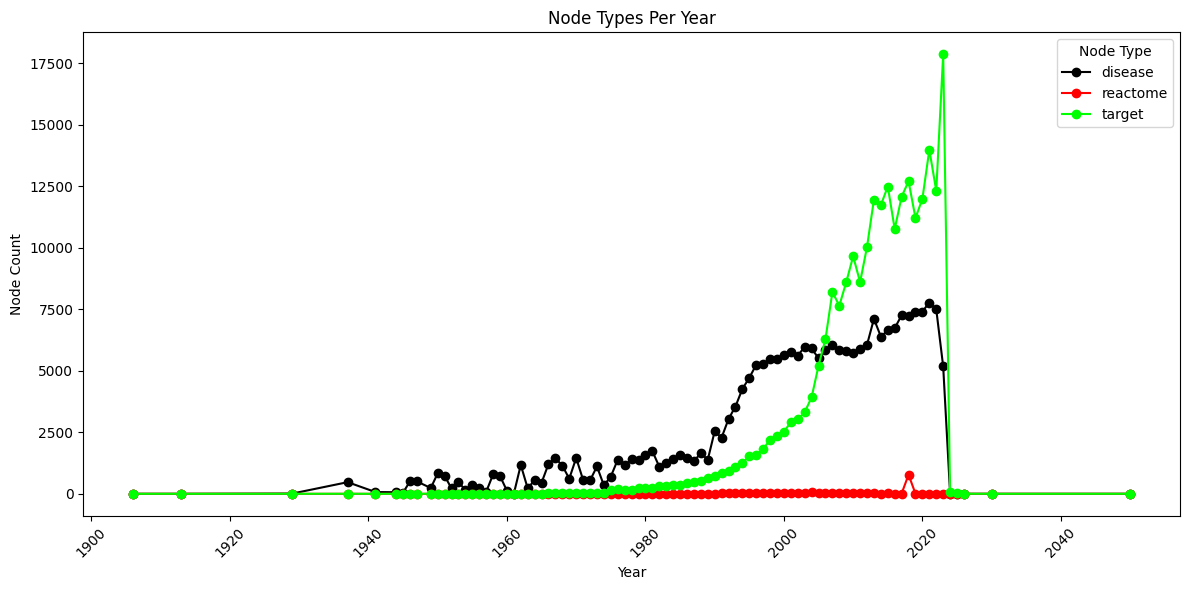

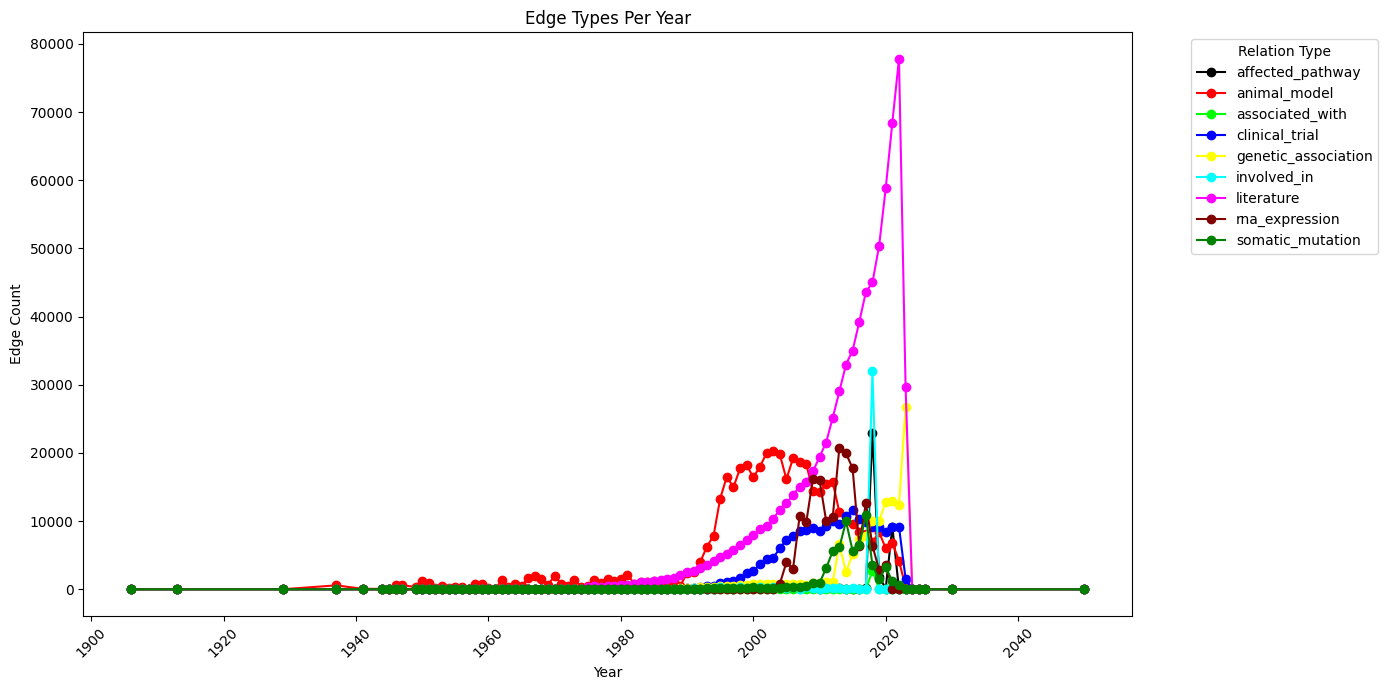

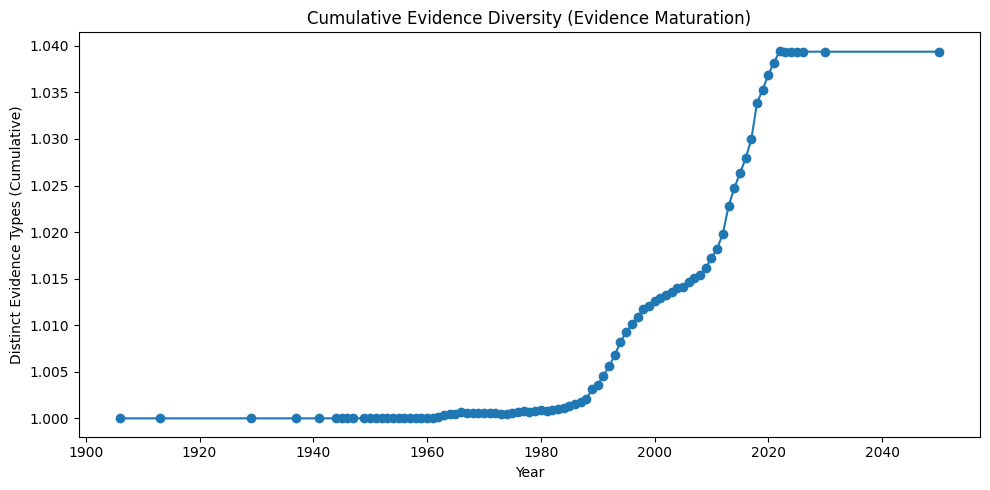

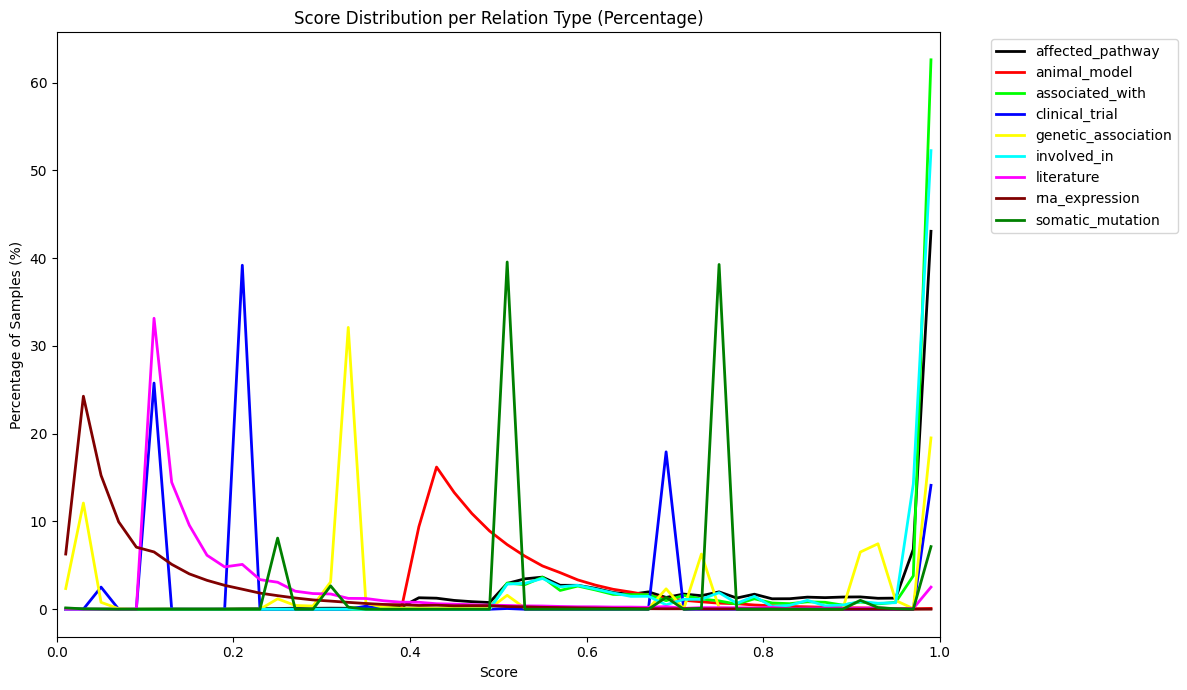

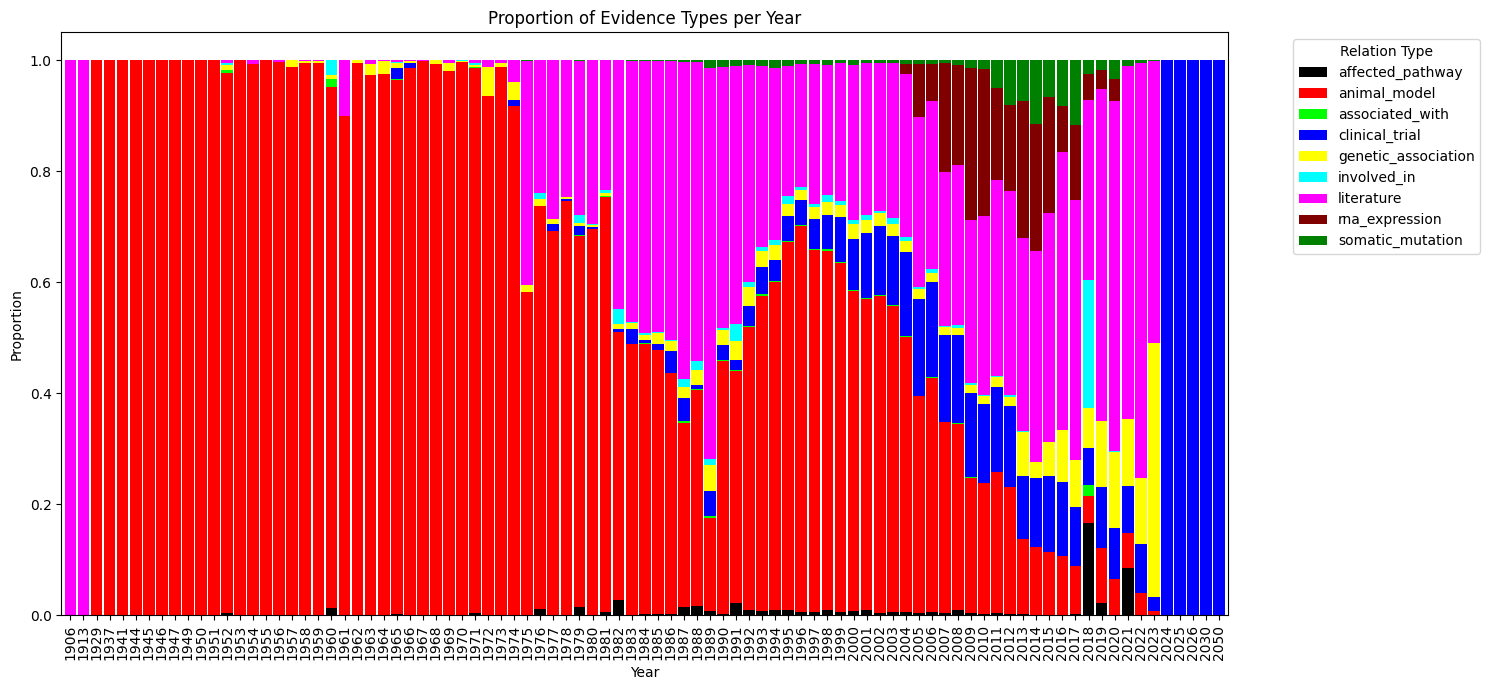

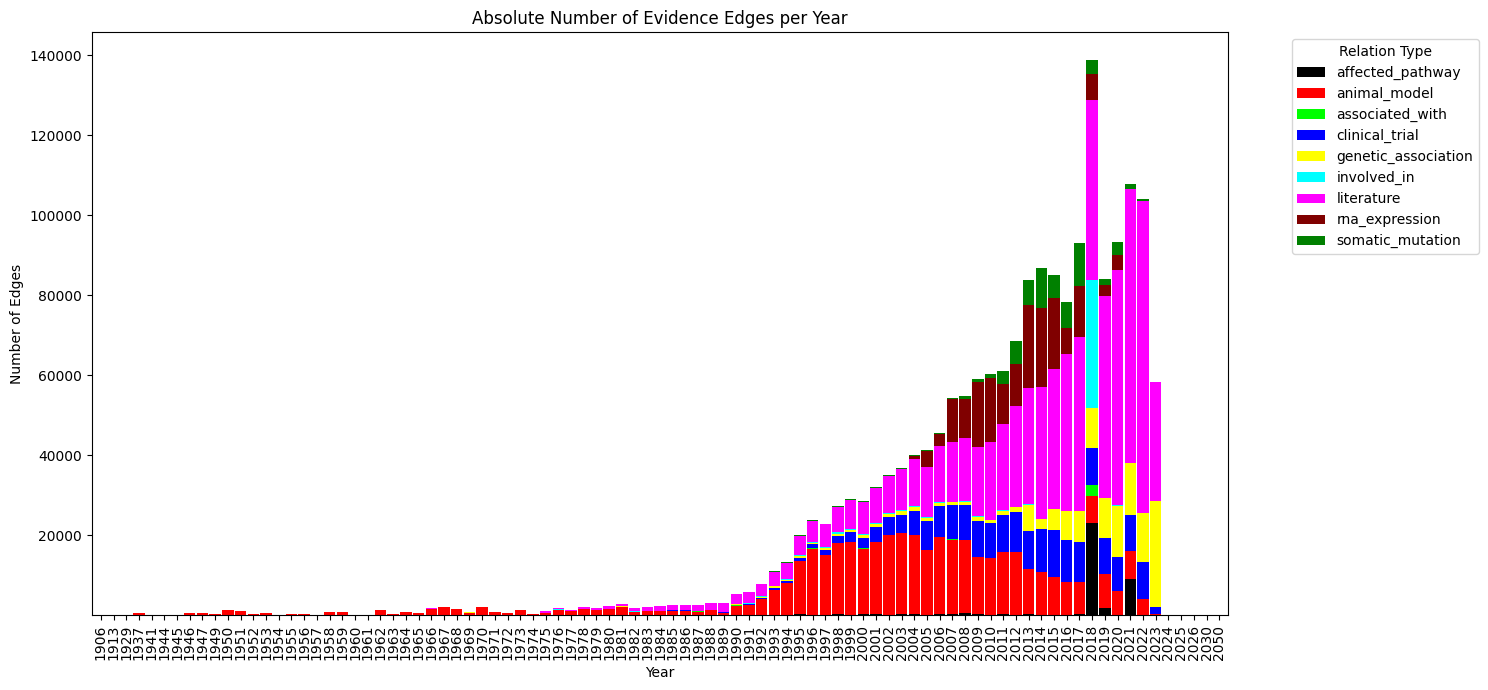

In [56]:
plot_node_type_per_year(plot_stats["node_type_per_year"], node_colors)
plot_edge_type_per_year(plot_stats["edge_type_per_year"], edge_colors)
plot_cumulative_evidence_diversity(plot_stats["cumulative_evidence_diversity"])
plot_score_percentage(plot_stats, edge_colors)
plot_evidence_proportion_per_year(plot_stats['evidence_proportion_per_year'], edge_color_map=edge_colors)
plot_evidence_counts_per_year(plot_stats['evidence_count_per_year'], edge_color_map=edge_colors)
